# Makemore from Scratch Part 3.2: Batch Normalization

In this notebook, I'm following along with the YouTube video [Building makemore Part 3: Activations & Gradients, BatchNorm](https://www.youtube.com/watch?v=P6sfmUTpUmc&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=4), where [Andrej Karpathy](https://www.youtube.com/@AndrejKarpathy) continues walking through the development and optimization of a language model from scratch.

This notebook covers the discussion of Batch Normalization that starts at about the 40 minute marker in the video.

## Batch Normalization

A [paper on Batch Normalization](https://arxiv.org/pdf/1502.03167.pdf), written by a team at Google, came out in 2015. 

The suggest using the following mathematical functions for normalizing hidden layers:

$$
\text{Input: Values of } x \text{ over a mini-batch: } B = \{x_1, x_2, \ldots, x_m\}
$$

$$
\text{Parameters to be learned: } \gamma, \beta
$$

$$
\text{Output: } \{y_i = BN_{\gamma,\beta}(x_i)\}
$$


$$
\mu_B = \frac{1}{m} \sum_{i=1}^{m} x_i \quad \text{Mini-batch Mean}
$$

$$
\sigma_B^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu_B)^2 \quad \text{Mini-batch Variance}
$$

$$
\hat{x}_{i} = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}} \quad \text{Normalize}
$$

$$
y_i = \gamma \hat{x}_{i} + \beta \equiv BN_{\gamma, \beta}(x_i) \quad \text{Scale and Shift}
$$


The insight from the paper is that you have hidden states and you want them to be roughly Gaussian, why not just take the hidden states and normalize them to be Gaussian. Standardizing hidden states to be roughly Gaussian is a perfectly differentiable operation. 

In [11]:
import torch
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [29]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
n_hidden = 200

hpreact = torch.randn((32, n_hidden), generator=g) * 10

(array([  1.,   0.,   0.,   1.,   2.,   2.,   4.,   4.,   1.,   8.,  11.,
         19.,  30.,  43.,  52.,  77., 104., 131., 158., 197., 222., 314.,
        324., 338., 340., 362., 357., 397., 377., 361., 361., 328., 244.,
        262., 184., 185., 138., 109., 106.,  82.,  55.,  37.,  18.,  20.,
          6.,  10.,   9.,   4.,   3.,   2.]),
 array([-41.87593842, -40.33698982, -38.79804123, -37.25909264,
        -35.72014404, -34.18119545, -32.64224686, -31.10329826,
        -29.56434967, -28.02540108, -26.48645248, -24.94750389,
        -23.4085553 , -21.8696067 , -20.33065811, -18.79170952,
        -17.25276093, -15.71381233, -14.17486374, -12.63591515,
        -11.09696655,  -9.55801796,  -8.01906937,  -6.48012077,
         -4.94117218,  -3.40222359,  -1.86327499,  -0.3243264 ,
          1.21462219,   2.75357079,   4.29251938,   5.83146797,
          7.37041656,   8.90936516,  10.44831375,  11.98726234,
         13.52621094,  15.06515953,  16.60410812,  18.14305672,
         19.682005

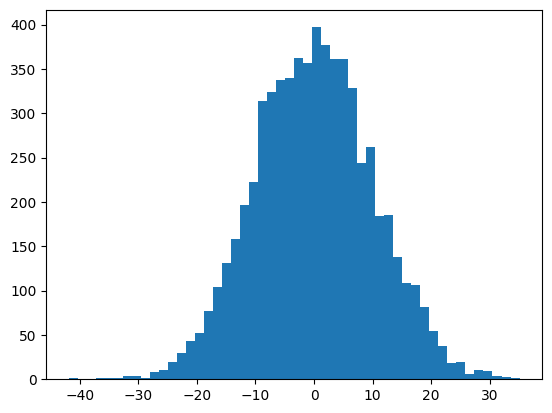

In [30]:
plt.hist(hpreact.view(-1).tolist(), 50)

In [31]:
hpreact.shape

torch.Size([32, 200])

In [32]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [33]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

To noramlize we subtract the mean and divide by the standard deviation. 

In [34]:
hpreact = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)

(array([  1.,   2.,   0.,   7.,   6.,   6.,   7.,  19.,  22.,  28.,  48.,
         41.,  94.,  81., 116., 141., 163., 186., 254., 267., 286., 270.,
        280., 307., 332., 325., 310., 335., 299., 312., 285., 241., 229.,
        178., 173., 152., 127., 107.,  88.,  76.,  66.,  36.,  30.,  24.,
         17.,  12.,   8.,   3.,   1.,   2.]),
 array([-3.36006522, -3.22971904, -3.09937285, -2.96902667, -2.83868049,
        -2.7083343 , -2.57798812, -2.44764194, -2.31729575, -2.18694957,
        -2.05660338, -1.9262572 , -1.79591102, -1.66556483, -1.53521865,
        -1.40487247, -1.27452628, -1.1441801 , -1.01383391, -0.88348773,
        -0.75314155, -0.62279536, -0.49244918, -0.36210299, -0.23175681,
        -0.10141063,  0.02893556,  0.15928174,  0.28962792,  0.41997411,
         0.55032029,  0.68066648,  0.81101266,  0.94135884,  1.07170503,
         1.20205121,  1.33239739,  1.46274358,  1.59308976,  1.72343595,
         1.85378213,  1.98412831,  2.1144745 ,  2.24482068,  2.37516686,
 

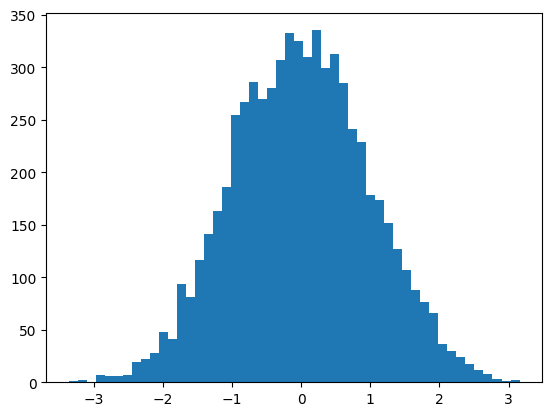

In [35]:
plt.hist(hpreact.view(-1).tolist(), 50)

This normalization function is differentiable and we could let the network do this through every forward pass and train the network. But, if we did the normalization during every forward pass, we wouldn't achieve a good result. We want them to be Gaussian during initalization, but not always. We'd like to allow the neural network to learn and move the shape around to make it more diffuse, to make it more sharp, or to make some tanh neurons be more/less trigger happy, etc. We'd like back-prop to tell us how it should move around. 

We can account for this by doing what's known as ***scale and shift***. We do this by initializing the following gain and bias terms and then apply them to hidden layer calculation so that they can be adjusted during back-propagation by the model.

In [37]:
# setup
n_hidden = 200
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

# during forward pass
hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias

If we run this with our single hidden layer MLP we wouldn't really get any improvement. But if we have a deeper neural network, it would be very difficult to tune the scales of the weight matrices so that all the activations are roughly Gaussian. It's much easier to sprinkle in batch normalization to every linear layer (e.g. the pre-activated hidden layer) and append batch normalization right after it. We can do the same thing with Convolution Layers, when we learn about them later. This helps us control the scale of the activations at every point in the neural net.

But this stability comes at a cost. Without batch normalization, we had a single example that feeds into the neural net and that would be a deterministic process where we'd calculate logits based on the example. Because of efficiency for training, we started batching. But now, with batch normalization, we are starting to couple these examples together mathematically in the forward / backwards pass. The calculated logits are no longer just a function of the examples, but they are now a function of that example and the other examples it randomly got batched with. Depending on the examples, our hidden layer can now "jitter". In a strange way, this can actually be good. It's like a regularizer because it effectively pads out any individual input example. As a second-order effect, it is basically a regularizer. 

But, the mathematical coupling of examples in batches can still lead to strange results and bugs. People have tried to deprecate batch normalization in favor of other approaches such as *layer normalization*, *group normalization*, and *instance normalization*. 

Batch was the first and it works quite well, so people haven't necessarily been able to easily replace it. 

## Test time

One thing that happens when we use batch normalization is that after training we no longer necessarily have batches. We may want to feed in a single example to get a single output back, or to assess the network loss during inference. 

So, after training, instead of calculating the mean and standard deviation of a batch, we can effectively "fix" the mean and standard deviation over the entire training set and use those values. 

```
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)
```

Then when we're calculating the loss, we can do:
```
hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias

```

Instead of calculating against the entire training set at the end, another approach is to calculate the bnmean and bnstd in a running fashion.

```
# during setup / initialization
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

# during training, we can calculate the mean for the i'th iteration

bnmeani = hpreact.mean(0, keepdim=True)
bnstdi = hpreact.mean(0, keepdim=True)
hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias

with torch.no_grad():
  bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
  bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
```

We're not using gradient descent to update these, since they're just values that we need post training, not as part of training. We're doing a running average type of calculation here. 

## Biases

When you're doing batch normalization, if you have any weight layers before (e.g. linear or convolusion), you don't need bias layers anymore. 

The way that batch normalization works is that it is taking the mean of the weights and subtracting it out during the normalization calculation. So, the gradient of the bias will always turn out to be 0. So, it's just a waste of calculations to even include the bias terms. When using batch normalization, just comment out your layer bias terms. 

```
# before
hpreact = embcat @ W1 + b1

# after
hpreact = embcat @ W1
```

The Batch Normalization bias is now responsible for biasing, so don't need bias in the layer before it.

## Normalization techniques

### Batch Normalization (BN)

Batch normalization is one of the earliest and most widely used normalization techniques.
It operates on a mini-batch of training examples and normalizes the activations of a layer by subtracting the mean and dividing by the standard deviation of the batch.

Batch normalization introduces learnable parameters (scale and shift) that allow the network to adapt the normalized activations.

It can be applied to various layers in a neural network, including convolutional layers and fully connected layers.

***Recommendation from Andrej: Generally try to avoid Batch Normalization layers because they introduce many issues that are hard to debug. Try Group Normalization and Layer Normalization instead.***

### Layer Normalization (LN)

Layer normalization normalizes the activations of a layer by computing the mean and standard deviation across all the units (neurons) in that layer.

Unlike batch normalization, it operates independently on each training example rather than a mini-batch.

Layer normalization is often used in recurrent neural networks (RNNs) where batch sizes can vary.

### Group Normalization (GN)

Group normalization is a compromise between batch normalization and layer normalization.

It divides the channels (feature maps) of a layer into groups and computes statistics (mean and standard deviation) separately for each group.

Group normalization is useful when the batch size is small or when the network has irregular channel dimensions.

### Instance Normalization (IN)
Instance normalization is a variation of batch normalization but applied independently to each training example rather than across a mini-batch.

It normalizes the activations of each example separately and does not include learnable parameters.

Instance normalization is commonly used in style transfer and image-to-image translation tasks.